# Users and Items: Finding the Right Customer Using Matrix Completion

## Introduction

In this chapter we examine a variety of approaches to building a recommender system, such as the type typically found on Amazon and Netflix. We will use an easy to install set of Python libraries to implement the systems, and examine the kind of predictions made when applied to a small "toy" data-set. Once we have established a feel for the kind of predictions these systems can make, we will assess the practicalities of applying them in the real world, comparing the approaches on some real-world data, examine a selection of initialisation variables, and considering repeatability and scaleability.  Finally, we will discuss the field of compressed sensing, an area of continuing research into the decomposition of matrix data.

###Libraries Used

We use a selection of libraries in this chapter, the full `import` roster is:

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as dist
import nimfa
import time
import matplotlib.pyplot as plt
from mpltools import style
from scipy.linalg import svd,diagsvd
from scipy import sparse
from sparsesvd import sparsesvd
from mpltools import style
style.use('ggplot')

All the libraries are available via `pip` on Linux or installed from the [pypi](https://pypi.python.org/pypi) website.

## Problem Statement

So let us imagine you have got a website doing great trade in widgets, selling them to users that you have registered. Cleverly, you've kept track of what users buy, so you have a complete picture of the site's shopping status. Great!, but how useful is this data? You really want to target customers with products they might have a genuine interest in without it being classed as "spam". The system you require is usually called a __Recommender System__ and should be an integral part of the marketing process in your business. 

There are two key things you can do with this type of system:

1. Recommend products that you think users will like, to the right user.
2. Figure out what stock you need.

So what does this type of data look like? The best way to structure the data is to present the "users" as rows and "items" as columns. This naturally forms a matrix with the amounts bought as elements and with missing values as the values we mainly wish to predict. Missing values are potential selling points, so we can target users with these products either through direct mail or product placement when they view the website. It also gives some indication of the amount of stock that might be required for each item. So a little shop selling ten items to eight customers would be best represented by a matrix that looks like this: 

$$
X = \left(
\begin{array}{ccccccccccc}
                      & Chocolate & TV & Peanuts & Crisps & Wine & Beer & Champagne & Ginger Beer & Lemonade & Orange Juice  \\ 
                Jim & 1  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & 2\\
                Brenda & 4  & \_ &  5 & 5 & 6 & 7 & 6 & \_ & 7 & 1\\
                Jonny & \_ & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_ \\
                Jo & 3  & \_ & \_ & 2 & 1 & 4 & 6 & 1 & 4  & \_\\  
                Rosa & 3  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_\\  
                Ruby & \_ &  3 &  3 & 4 & 4 & 4 & 4 & 5  & 6 & 2\\ 
                Julie & 3  & \_ & \_ & 2 & 1 & 4 & 6 & \_ & 5 & \_\\
                Karen & 3  & 6  & \_ & \_ & \_ & \_ & \_ & \_ & 5 & 2 \\
                \end{array} 
\right)
$$

This we will call the "Source" matrix, Each row/column combination records how much of a product (column) has been bought by a user (row).
In addition, we might simplify this view to generate a binary "interaction" matrix. This is the above data simplified to record whether an item has been bought (1) or not (_). 

$$
X_b = \left( \begin{array}{ccccccccccc}
                       & Chocolate & TV & Peanuts & Crisps & Wine & Beer & Champagne & Ginger Beer & Lemonade & Orange Juice  \\ 
                Jim & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & 1\\
                Brenda & 1  & \_ &  1 & 1 & 1 & 1 & 1 & \_ & 1 & 1\\
                Jonny & \_ & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_ \\
                Jo & 1  & \_ & \_ & 1 & 1 & 1 & 1 & 1 & 1  & \_\\  
                Rosa & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_\\  
                Ruby & \_ &  1 &  1 & 1 & 1 & 1 & 1 & 1  & 1 & 1\\ 
                Julie & 1  & \_ & \_ & 1 & 1 & 1 & 1 & \_ & 1 & \_\\
                Karen & 1  & 1  & \_ & \_ & \_ & \_ & \_ & \_ & 1 & 1 \\
                \end{array} 
\right)
$$

In Numpy this would look something like this:

In [2]:
import numpy as np
#generate the data for this chapter
X = np.array([[1,0,0,2,1,4,6,0,5,2],
             [4,0,5,2,1,4,6,0,5,1],
             [0,0,0,2,1,4,6,1,4,0],
             [3,0,0,2,1,4,6,0,5,0],
             [3,0,0,2,1,4,6,0,5,0],
             [0,3,3,4,4,4,4,5,6,2],
             [3,0,0,2,1,4,6,0,5,0],
             [3,6,0,0,0,0,0,0,5,2],])
Xb = X.clip(0,1) #clip ound everything above 1 to 1
print "X=\n" + str(X)
print "Xb=\n" + str(Xb)


X=
[[1 0 0 2 1 4 6 0 5 2]
 [4 0 5 2 1 4 6 0 5 1]
 [0 0 0 2 1 4 6 1 4 0]
 [3 0 0 2 1 4 6 0 5 0]
 [3 0 0 2 1 4 6 0 5 0]
 [0 3 3 4 4 4 4 5 6 2]
 [3 0 0 2 1 4 6 0 5 0]
 [3 6 0 0 0 0 0 0 5 2]]
Xb=
[[1 0 0 1 1 1 1 0 1 1]
 [1 0 1 1 1 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [0 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 0 0 0 1 1]]


 We replace the blanks with zeros, knowing these are the values we need to estimate. Once we have estimated the blanks we can build a recommendation. Looking at the above matrix a sensible recommendation might be Chocolate for Ruby and Ginger Beer for Rosa, when the user next logged onto the website this would be shown in the now common "we recommend" element usually towards the bottom of the page. For Ruby the first item would be Chocolate and for Rosa this would be Ginger Beer.
 
 
##Recommender Algorithms
 
  The big question is how might we do this? The most obvious approach is to use what we know about similar user's purchasing patterns to predict user's unknown values. Likewise, we can also use what we know about how similar products have sold to predict a product's unknown values. These approaches are known as __Collaborative Filtering__. A second less obvious method from the field of statistics is to try and predict the underlying drivers for the _user buys item_ decision process using a __Latent Factor Model__ in our case using __Non-negative Matrix Factorisation__ and  __Singular Valued Decomposition__. We will discuss each one of these individually in the following sections.

### Collaborative Filtering

Collaborative Filtering was the first and the simplest approach to this kind of problem. The main idea is interpolate missing values by comparing users with a number (which we call $K$) of similar users. This is similar to the clustering approach discussed in Chapter .., and it works in a similar way by calculating a _general_ smoothed value. The same approach can be applied along the item's axis, which may be more efficient as most businesses have less items than users. 
The general algorithm is as follows (using rows as example):

1. For each row vector.
2. Find the K nearest users, let us call them $U$.
3. Calculate new vector $= Agg(U)$ and use this in the place of the old value.

For the first part of the algorithm, the word _nearest_ means calculating a distance to each of the users in the data-set. Several distance measures exist, and they differ depending on the nature of the recommender data-set (Source or Interaction as defined in the Problem Statement).
We will look at the interaction data-set with something called __Jaccard Distance__. This is a set theoretic distance that calculates the relative overlap of two vectors (a single row of the above user/item matrix). The equation for the distance is:

$$
Jacc(x,y) = 1 - \frac{x \cap y}{x \cup y}
$$

The overlap (Intersect) is scaled by the overall set size (the union):
So let us look at an example two sets from our example data-set $X_6$ and $X_7$ 

$x = [1 0 0 1 1 1 1 0 1 0]$ and  $y =[0 1 1 1 1 1 1 1 1 1] $

The intersect is $x \cap y = 5$

The union is $x \cup y = 10$

$Jacc(x,y) = 1 -  0.5 = 0.5$

In `python scipy` a variety of distance measures are available, _Jaccard_ is applied using `pdist`:

In [3]:
import scipy.spatial.distance as dist
print dist.pdist(Xb[5:7,:], 'jaccard')

[ 0.5]


For the second aggregation part of the algorithm, an obvious $Agg(U)$ function is for each row entry ($x_{ij}$) to _mean and threshold._ 

Below is this algorithm in Python. The initial Jaccard distance matrix is an upper triangular matrix
of the form:


$$
D = (d_{01},d_{12},d_{02}) = \left(
\begin{array}{ccc}
0 & d_{01} & d_{02}    \\
\_ & 0 & d_{12}   \\
\_ & \_ & 0  \\
\end{array} \right) 
$$

This is converted to a standard matrix using the `squareform` function. 

$$
squareform(D) =
\left(
\begin{array}{ccc}
0      & d_{01} & d_{02}   \\
d_{01} & 0      & d_{12}   \\
d_{02} & d_{12} & 0  \\
\end{array} \right) 
$$

Next, for each row an indices based sort is performed and this is truncated to the $K$ desired number of nearest neighbours. This is then used as indices for $Xb$ and each value is averaged (using `mean` along the columns). This is then thresholded to return to binary values.

In [21]:
import scipy.stats as stats
#produce a distance matrix 
K=3
Y = dist.squareform(dist.pdist(Xb, 'jaccard'))
#find the closest K rows
U = np.argsort(Y)[:,:K]
print U
#average them
out = np.mean(Xb[U],1)
#threshold back to binary
out = stats.threshold(out,threshmax=0.5,newval=1)
out = stats.threshold(out,threshmin=0.49,newval=0)
print Xb
print "X'=\n"+str(out)

[[0 1 3]
 [1 0 3]
 [2 3 4]
 [3 4 6]
 [3 4 6]
 [5 1 2]
 [3 4 6]
 [7 0 1]]
[[1 0 0 1 1 1 1 0 1 1]
 [1 0 1 1 1 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [0 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 0 0 0 1 1]]
X'=
[[ 1.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  1.]]


The same approach can be applied on an item by item basis, this is easily performed with the same code on the transpose ( `.T` flipped on the diagonal) of the matrix. _item 1_ (`X[:,0]`) is a good bet to be sold to the users who haven't purchase it yet - particularly _User 3_ (`X[2,:]`) who has a history of buying. _User 8_ has a selection of products that they haven't bought that similar users have heavily purchased. 

In [5]:
#Flip the matrix along the diagonal
Xbt = Xb.T
#produce distance matrix
K=3
Y = dist.squareform(dist.pdist(Xbt, 'jaccard'))
#find the closest K rows
U = np.argsort(Y)[:,:K]
#average them
out = np.mean(Xbt[U],1)
#threshold back to binary
out = stats.threshold(out,threshmax=0.5,newval=1)
out = stats.threshold(out,threshmin=0.49,newval=0)
#flip back
print "X'=\n"+str(out.T)

X'=
[[ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]]


Again, _item 1_ (`X[:][0]`) is a good bet to be sold to the users who haven't purchase it yet. Can you see how applying the mean $Agg(U)$ function smooths out the data? There are a multitude of distance measures and $Agg$ variations that can be used to make this system more sophisticated.  

### Latent Models

The second approach is to find the model _behind_ the data, the __Latent Factor Model__. So what is a Latent Factor? 
If the web-shop we have just modelled as a matrix were a music shop, then the latent factors might be the year of the music (I'm a 90's guy) and the genre (gosh do they still call it grunge!). So these two factors 
(_decade,genre_) might be the main differentiating factor, though the catalogue data may be _(year,band-name,album-name,sales,rating)_. Many real-world decisions are driven by a latent model of some sort, including purchasing, voting and dating! Here's the downside with latent 
factors - unless the data is really simple (or you have semantic meaning in the model) then figuring out the 
factors is difficult, the factor class __labels__ (_decade_, _genre_ for the music shop) are only recoverable with human interpolation. For our problem the general method used is to factorise the source/interaction matrix into smaller simpler constituent parts, the methods discussed below,__Non-negative Matrix Factorisation__ and __Singular Valued Decomposition__ differ by the structure of the latent model.

###Non-negative Matrix Factorisation

Non-negative Matrix Factorisation is a simple factorisation into two latent matrices - the user model $U$ and the item model $V$. This manifests itself in a purely mathematical form as a dot product multiplication between two latent matrices. The overall model is:

$X = U.V$

where X is either a source matrix or an interaction matrix: 

$$
U = \left(
\begin{array}{ccc}
 u_{00} & u_{01} & u_{02}  \\
 u_{10} & u_{11} & u_{12}  \\
 u_{20} & u_{21} & u_{22}  \\
 u_{30} & u_{31} & u_{32}  \\  
 u_{40} & u_{41} & u_{42} \\  
 u_{50} & u_{51} & u_{52}  \\ 
 u_{60} & u_{61} & u_{62}  \\
 u_{70} & u_{71} & u_{72}  \\
\end{array} 
\right) \, \text{and } V = \left(
\begin{array}{cccccccccc}
 v_{00}  & v_{01} & v_{02} & v_{03} & v_{04} &v_{05} & v_{06} & v_{07} & v_{08} & v_{09} \\
 v_{10}  & v_{11} & v_{12} & v_{13} & v_{14} &v_{15} & v_{16} & v_{17} & v_{18} & v_{19} \\
 v_{20}  & v_{01} & v_{02} & v_{23} & v_{24} &v_{25} & v_{26} & v_{07} & v_{28} & v_{29} \\
\end{array}
\right)
$$


The dot product ($.$) of two matrices is:
$$
x_{ij}=\sum^K_{k}u_{ik}\times v_{kj}
$$

The matrices sizes in the product are related by size by the following: $(I,J) = (I,K).(K,J)$
in the above case there are three latent factors so: $(8,10) = (8,3).(3,10)$ 
To perform a multiplication in `Numpy` we use the function `numpy.dot(x,y)`

In [6]:
x = np.array([[1,2],[3,4]])
y = np.array([[5,6,7],[8,9,10]])
#multiply using the dot product
print "Final product=\n"+str(np.dot(x,y))

Final product=
[[21 24 27]
 [47 54 61]]


So how do we get to factor matrices? Well there
are many approaches, the most amenable finds P and Q directly with a guess 
work based process where one knows how to judge how well you are 
doing (an error function). An iterative minimisation of this error function is performed using knowledge of the gradient and how it relates to the $U$,$V$ matrices.

The algorithm is briefly as follows:

1. Start with random $U$ and $V$
2. Generate and estimate for ($X'$)
3. Calculate the error between $X'$ and $X$
4. Adjust the random matrices to be closer to the right answer knowing how a change 
    in U and V effects the error
5. Iterate 2-4 until you run out of time or you hit an error you are happy with

For this work we will use the library called [nimfa](http://nimfa.biolab.si) since it covers a large spectrum of factorisation algorithms and is simple and quick to apply. Below is the Python code to solve this problem, we first calculate the factorisations and then recalculate the X matrix, and show the original X matrix to contrast. 

In [7]:
import nimfa 
#specify nmf model for X
model = nimfa.mf(X, method = 'nmf', rank = 2,max_iter=1000)

#fit the model
fit = nimfa.mf_run(model)
#get U and V matrices from fit
U = fit.basis()
V = fit.coef()

#let's have a look at them
print "X=\n"  + str(X)
print "U=\n" + str(U.round(1))
print "V=\n" + str(V.round(1))
print "X'=\n" + str(np.dot(U,V).round())

X=
[[1 0 0 2 1 4 6 0 5 2]
 [4 0 5 2 1 4 6 0 5 1]
 [0 0 0 2 1 4 6 1 4 0]
 [3 0 0 2 1 4 6 0 5 0]
 [3 0 0 2 1 4 6 0 5 0]
 [0 3 3 4 4 4 4 5 6 2]
 [3 0 0 2 1 4 6 0 5 0]
 [3 6 0 0 0 0 0 0 5 2]]
U=
[[ 0.3  4.6]
 [ 1.   5. ]
 [ 0.   4.2]
 [ 0.   4.8]
 [ 0.   4.8]
 [ 7.6  3.3]
 [ 0.   4.8]
 [ 8.4  0. ]]
V=
[[ 0.1  0.6  0.2  0.1  0.2  0.1  0.   0.3  0.5  0.2]
 [ 0.4  0.   0.2  0.5  0.2  0.9  1.3  0.1  1.   0.1]]
X'=
[[ 2.  0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2.  1.  1.  2.  1.  4.  6.  1.  5.  1.]
 [ 2.  0.  1.  2.  1.  4.  5.  0.  4.  0.]
 [ 2.  0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2.  0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2.  4.  2.  3.  2.  3.  4.  2.  7.  2.]
 [ 2.  0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 1.  5.  1.  1.  2.  1.  0.  2.  4.  2.]]


Can you see what has happened? The simplified matrices have made predictions for each of the values in the matrix based on a simplified belief about the latent model. Some of the known values have changed since this is the best the latent model can do given the decreased number of model parameters. The value at the intersection of a user who buys and a product that sells `X'[5][0]` have been increased to 2! Therefore we can recommend where the marketing spend should head!! 
Due to the flexibility of `nimfa` we can also apply this to binary matrix for this we simply run the same Python with method set to `"bmf"`

In [8]:
#specify nmf model for Xb the binary matrix
model = nimfa.mf(Xb,rank = 2, method = "bmf",max_iter=40)

#fit the model
fit = nimfa.mf_run(model)
#get U and V matrices from fit
U = fit.basis()
V = fit.coef()

#print the matrices again
print "X=\n"  + str(Xb)
print "U=\n" + str(U.round(1))
print "V=\n" + str(V.round(1))
print "X'=\n" + str(np.dot(U,V).round())

X=
[[1 0 0 1 1 1 1 0 1 1]
 [1 0 1 1 1 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [1 0 0 1 1 1 1 0 1 0]
 [0 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 0 0 0 1 1]]
U=
[[ 1.   1. ]
 [ 1.   1. ]
 [ 0.3  1. ]
 [ 1.   0.8]
 [ 1.   0.8]
 [ 0.2  1.2]
 [ 1.   0.8]
 [ 0.6  0.3]]
V=
[[ 1.   0.   0.   0.   0.1  0.2  0.8  0.   0.3  0. ]
 [ 0.   0.2  0.3  1.   0.9  0.9  0.3  0.3  0.8  0.5]]
X'=
[[ 1.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 0.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  1.  1.  1.  0.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


So again _product1_ (`X[:,0]`) looks like it could sell to two extra users - but _user8_ buying it didn't fit the model.The last row (`X[7,:]`) has some tension as a user who has bought the least, could be recommended  products that have sold to all users, the binary version of NMF falls on the side of the user not buying.

We've used a very simple model here and the results are starting to make sense, one variation that can be generated is not to treat zeros as zeros but rather to use them as place holders for "unknown", and not to change any known values. This method together with a python implementation are explained in [this blog](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/). So we've run the little simulation and you have in your head how this process might help in your problem domain, what are the  practical considerations? There are three major questions to pose:

1. How does the algorithm scale?
2. What are my initialisation parameters going to be?
3. Are the factorisations unique?

#####Scaling

Scaling is an important issue which needs to be addressed - in 
practice the algorithm requires a minimisation process so there is 
time spent descending an error surface. Let us again experiment and 
perform randomised descents on progressively larger data-sets plotting
the time against matrix size. 

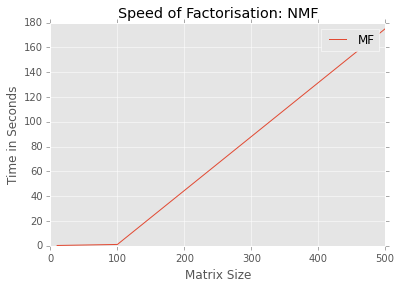

In [9]:
import time
import nimfa
import matplotlib.pyplot as plt
#set up the plotting so it looks like R!


#DANGER MIGHT TAKE A WHILE TO RUN
testSize =[(10,2),(100,10),(500,50)]#,(1000,50)]#,(3000,100)]
timeOut = []
for i in testSize:
    #build a random matrix 
    bigX = np.random.random_integers(100, size=(i[0],i[0]))    
    #start the clock
    start = time.clock()
    #perform the fit
    model = nimfa.mf(bigX, method = 'nmf', rank = i[1],max_iter=1000)
    fit = nimfa.mf_run(model)
    #stop the clock
    timeOut.append((time.clock() - start))
xaxis = [i[0] for i in testSize]
plt.plot(xaxis,timeOut,label="MF")
plt.xlabel("Matrix Size")
plt.ylabel('Time in Seconds')
plt.title('Speed of Factorisation: NMF')
plt.legend()
plt.show()


So we are taking a couple of minutes for a $(500,500)$ model, it might be that processing becomes an issue with tens of thousands of users.

#####Initialisation

`Nimfa` has a multitude of initialisation values including different implementations, that are worth exploring in advanced work. We've used basic defaults, to the most established method.
The main decision is the number of latent factors, is there a rule of thumb for 
this? In practice this is highly data dependent. One method is to 
try a few and look at how well the error measure is minimised - this 
gives a feel for how well the models fits the data. From my own experimentation my thoughts are "keep 
it low!" I've run factorisations with 10000 users and kept it well below 100. Predictably there
are ["infinite" models](ref), which mean there are models that will guess (through Monte Carlo sampling)
the best number of values for N.

#####Uniqueness
Are the factorisations unique? We can test this with a little reverse engineering.

In [10]:
#start with a U V calculate and X then check we return to U V 

#build the target matrices
targetU = np.array([[1,2],[3,4],[5,6]])
targetV  = np.array([[1,2,3],[4,5,6]])
targetX  = np.dot(targetU,targetV)

#fit the NMF model
model = nimfa.mf(targetX, method = 'nmf', rank = 2,max_iter=1000)
fit = nimfa.mf_run(model)
U = fit.basis()
V = fit.coef()
#calculate the target matrix
Xm = np.dot(U,V)
#Are they the same?
print "X=\n"+str(targetX)
print "Xm=\n"+str(Xm.round())
print "U=\n" + str(U.round(1))
print "V=\n" + str(V.round(1))
#Answer "NO!"

X=
[[ 9 12 15]
 [19 26 33]
 [29 40 51]]
Xm=
[[  9.  12.  15.]
 [ 19.  26.  33.]
 [ 29.  40.  51.]]
U=
[[ 10.2  10.7]
 [ 50.4   2.4]
 [  1.   60.3]]
V=
[[ 0.4  0.5  0.6]
 [ 0.5  0.7  0.8]]


So it's clear that this factorisation is not guaranteed to reliably recover known latent matrices. This is a definite weakness of this approach.

###Singular Valued Decomposition

An alternative method for calculating a latent model relies on a mathematical miracle worker called the 
Singular Valued Decomposition (SVD) - what is this? 

In the world of matrices one of the most used methods is the eigendecomposition ($evec, eval$, which we touched upon with PCA). The SVD is a special form of factorisation that comes in the form:

$X = U.S.V^T$


The S matrix is cleverly organised so that a "good guess" latent model with $K$ factors can be generated by truncating the diagonal of S so that only  the left most _strongly representative_ values remain. 
$$X' = U.S_{trunc}.V^T$$

Taking a simple 3x2 matrix as an example, we form the rank 1 truncated matrix as:

$$
\mathcal{X'} = \left(
\begin{array}{ccc}
 x_{00} & x_{01} &   \\
 x_{10} & x_{11} &   \\
 x_{20} & x_{21} &   \\
\end{array} 
\right) = \left(
\begin{array}{ccc}
 u_{00} & u_{01} & u_{02}  \\
 u_{10} & u_{11} & u_{12}  \\
 u_{20} & u_{21} & u_{22}  \\
 \end{array}
\right)
. \left(
\begin{array}{ccc}
  s_{0} & 0   \\
 0 & s_1=0  \\
 0 & 0   \\
\end{array} 
\right) .
\left(
\begin{array}{cc}
 v_{00} & v_{01}  \\
 v_{10} & v_{11}  \\
\end{array} 
\right)
$$

The number $K$ can be assessed graphically by looking at _elbow_ plot. This is formed by plotting the values of $S^2$, the "elbow" is the point at which reconstructional energy is sufficient to form a _reasonable_ compressed view (this is demonstrated in the Python below). In `scipy` the singular values $S$ is produced as a 1D array which in the example below I truncate at 2 (just below the elbow in the graph), and then return to a 2D matrix using the `diagsvd` command:

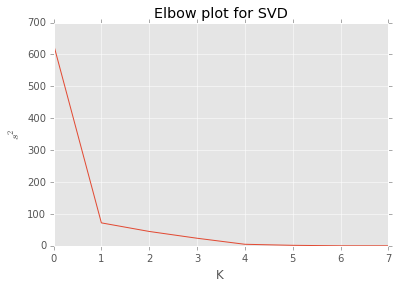

X=
[[1 0 0 2 1 4 6 0 5 2]
 [4 0 5 2 1 4 6 0 5 1]
 [0 0 0 2 1 4 6 1 4 0]
 [3 0 0 2 1 4 6 0 5 0]
 [3 0 0 2 1 4 6 0 5 0]
 [0 3 3 4 4 4 4 5 6 2]
 [3 0 0 2 1 4 6 0 5 0]
 [3 6 0 0 0 0 0 0 5 2]]
U=
[[-0.4  0.1 -0.   0.3  0.8 -0.4  0.  -0. ]
 [-0.4  0.1 -0.1 -0.9  0.2  0.2 -0.  -0. ]]
V=
[[-0.2 -0.1]
 [-0.  -0.7]
 [-0.6 -0.2]
 [-0.4  0.2]
 [-0.5 -0. ]
 [-0.4  0.4]
 [ 0.3  0.2]
 [-0.  -0.2]
 [ 0.  -0.3]
 [ 0.1  0.2]]
X'=
[[ 2.  0.  1.  2.  1.  4.  6.  1.  5.  1.]
 [ 2.  1.  1.  2.  1.  4.  6.  1.  6.  1.]
 [ 2. -0.  1.  2.  1.  4.  5.  0.  4.  0.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 2.  4.  2.  3.  2.  3.  4.  2.  7.  2.]
 [ 2. -0.  1.  2.  1.  4.  6.  0.  5.  0.]
 [ 1.  5.  2.  1.  2.  1. -0.  2.  4.  2.]]


In [11]:
from scipy.linalg import svd,diagsvd
#simple calculate of the necessary SVD matrices
U, s, Vh = svd(X)
#plot the elbow plot
plt.plot(s**2)
plt.xlabel("K")
plt.ylabel('$s^2$')
plt.title('Elbow plot for SVD')
plt.show()
#truncate to 2 
s[2:]=0
#calculate estimate using truncated S
outX = np.round(np.dot(np.dot(U,diagsvd(s,8,10)),Vh))
#show results
print "X=\n"+str(X)
print "U=\n"+str(U[:2,:].round(1))
print "V=\n"+str(Vh[:,:2].round(1))
print "X'=\n"+str(outX)

The results seem to follow the answers in previous sections with prediction in the two key places - the eager buyer with the sell-able product (`X[0][5]` and the all sell-able products, `X[7][3:6]`. There seems to be a consensus from all the models that these are where to target any marketing effort! 

The above results are produced by an analytic route and what is really useful is that looking at the Rank of singular values (number of non zero values), we can see how much representative power is contained in the respective low factorisation models. So that's all really useful and represents a step forward from the factorisation approach. So what about practical application, does this work in practice. Let us look at how the algorithm scales for some random sample matrices: 

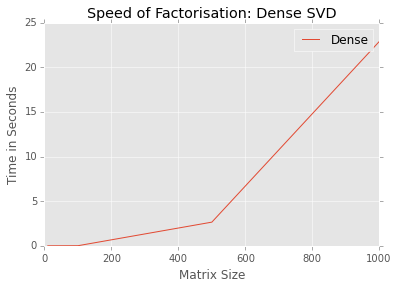

In [12]:
#run a test to see how long the SVD takes
#some sizes to test THIS MIGHT BE SLOW!!
testSize =[(10,2),(100,10),(500,50),(1000,50)]#,(3000,100),(10000,100)]
#the output matrix D for dense
timeOutD = []
#DANGER SLOW
for i in testSize:
    #buid a random matrix of correct size
    bigX = np.random.random_integers(100, size=(i[0],i[0]))
    #start the clock
    start = time.clock()
    #perform SVD start to finish
    U, s, Vh = svd(bigX)
    s[:i[1]]=0
    outX = np.dot(np.dot(U,diagsvd(s,i[0],i[0])),Vh)
    #stopt the clock
    timeOutD.append((time.clock() - start))

#plot the results
xaxis = [i[0] for i in testSize]
plt.plot(xaxis,timeOutD,label="Dense")
plt.xlabel("Matrix Size")
plt.ylabel('Time in Seconds')
plt.title('Speed of Factorisation: Dense SVD')
plt.legend()
plt.show()

This method scales better than the NMF approach in the previous example. 
If the matrices contain lots of zeros, a further scaling step can be gained
by using sparse instead of dense matrices. A sparse is not held in as a continuous block array, rather it is held by one of a collection
of reference based storage methods. A commonly used one is Compressed Sparse Column (CSC) matrix. This format
is based on the [Yale format](http://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_column_.28CSC_or_CCS.29) which broadly speaking, stores indices and values ignoring any zeros.
The format is optimised for multiplication, so that suits us for this particular problem.
In Python there is a standard for these matrices used in the `scipy` package. Thankfully,
there is also a sparse SVD package ([sparsesvd](https://pypi.python.org/pypi/sparsesvd/))  that allows use to produce SVD's from the `scipy` sparse format. Let us look at comparing these with the "dense" method:

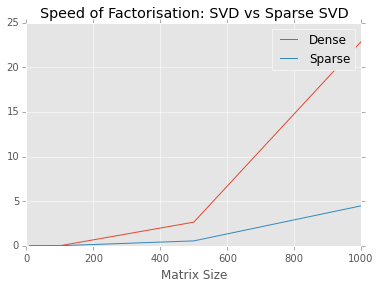

In [13]:
from scipy import sparse
from sparsesvd import sparsesvd
testSize =[(10,2),(100,10),(500,50),(1000,50)]#,(3000,100)],(10000,100)]
#array to record sparse times
timeOutS = []
#Should be a bit faster!!!
for i in testSize:
    #build a sparse matrix using sparse data source: P(0.1) of a 1
    bigX = mat = np.random.binomial(1,0.1,size=[i[0],i[0]])
    #start the clock
    start = time.clock()
    Xs = sparse.csc_matrix(bigX) # convert to sparse CSR format
    ut, s, vt = sparsesvd(Xs,i[1]) #perform sparse svd with but only for i[1] factors
    #slight fiddle take the transpose of ut 
    np.dot(ut.T, np.dot(np.diag(s), vt))
    timeOutS.append((time.clock() - start))

#graph this against the previous result
xAxis = [i[0] for i in testSize]
plt.plot(xAxis,timeOutD, label="Dense")
plt.plot(xAxis,timeOutS,label="Sparse")
plt.xlabel("Matrix Size")
plt.title('Speed of Factorisation: SVD vs Sparse SVD')
plt.legend()
plt.show()

Clearly "sparse" encoding makes this approach more viable, and the sparse matrix by definition should be a bit kinder on memory usage. We are almost at a stock system that could be easily developed once the data is clean enough.

####Cold Start

One limitation to note that often gets overlooked, is how sensitive these methods are to the amount of data available. Clearly with Latent Factor Models, you may find yourself initially with practically no data, this is called the "cold start". Any row and column with at least one element will be able to make some kind of prediction at the intersect, but it will only be weakly indicative. As your matrix becomes more populated you can start making more confident predictions. When using SVD the elbow plot is again a source of information on whether you have enough data, if the ratio of elbow position to matrix size is small then you know the predictions will be weak.

##Comparing Recommender Performance

So we now have a collection of techniques that are applicable to both integer and binary data, what we don't know is which one is most suited to solving the problem, we need some some _test data_ and a _error metric_ to assess how each technique performs. Since we have binary data we will focus on this case, however the process is repeatable for integer data 



The data we've got is simulated shopping data (note to editor: I'd like to replace this with some real world data if possible)  the initial test file is stored as a csv file and read in using the `numpy` `loadtxt` function, a standard way of reading in CSV files. When data gets large one of the best ways of appreciating binary files is to turn them in to images - this is easy in matplotlib with the function `matshow`, the `cmap` variable controls the colour in the image - below uses white for one and black for zero.

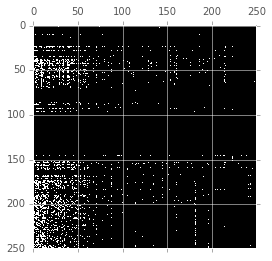

In [14]:
from scipy.sparse import *
X = np.loadtxt("mtrain.dat",delimiter=',')
plt.matshow(X,cmap='Greys_r')
plt.show()

###Test Data
To build a test file we need to remove some of the known ones, this is again easily performed in `numpy` used a small _vectorized_ `numpy` function. A vectorized function is one that can be applied efficiently to each item in a `numpy` matrix. We build a function that flips ones with a probability, for demonstration lets flip 50% of the values just so we can clearly see it works    

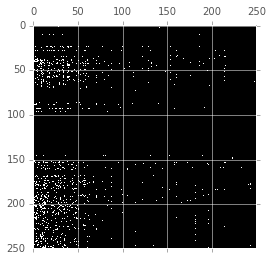

In [15]:
import random
@np.vectorize
def flip(a,b):
    return 0 if a==1 and random.random()<b else a
Xflip = flip(X,0.5)
plt.matshow(Xflip,cmap='Greys_r')
Xflip = flip(X,0.1)
plt.show()

In practice there is one weakness of this approach 
###Error Metric 

So we can see that some of the gone data has been removed - we hope that the systems discussed above can predict these in some way and to figure out how well we need an _error metric_. This error metric needs to assess how far away a predicted matrix is from the original known "target" matrix . The error should be low cases where the matrix matches well and high for case where it does not match. A measure that is often used in these situations is Root Mean Squared error (RMS) - an error is generated by squaring the difference between the target and actual and then the this number is averaged and a square root taken to normalise:

$$
RMS(t,d) = \sqrt{\frac{1}{SIZE}\sum_{i}^{SIZE} (t_{i}-d_{i})^2}
$$

The problem with using this measure for our binary data is that we only have predictions for how well the system can guess known one's but we have no measure of how well it can do on unknown zeros - those parts of the data that remain zeros when the prediction is made. Really in the above matrix zero means two thing - it means "no known prediction" as well as zero. We can take two approaches to solving this problem. We can ignore it in view of the fact that this is a comparative or we can make the underlying assumption that a random sample of from the matrix will be all zero given that the data is sparse. The ratio of the size of the known ones to the random sample is a simple way of reflecting how we feel about a priori about the structure of matrix, a ratio of 1 would indicate that we feel that there is as many one's and zeros.  Therefore we modify the RMS measure to measure known ones and unknown zeros ( $\#1$ is the size of the set of known ones): 

$$
SampledRMS(t,d) = \sqrt{\frac{1}{2\times\#1}(\sum_{i\:where\:t_i=1 }^{\#1}(t_{i}-d_{i})^2 + \sum_{i=random\:0}^{\#1}(t_{i}-d_{i})^2)}
$$


In [16]:
import math
def errors(inTarget,inActual):
    
    #split the target dataset into 1 and 0
    index1 = inTarget==1
    index0 = inTarget==0
    #calculate the 1's error
    error1s = np.power(inTarget[index1]- inActual[index1],2)
    #calculate the 0's error
    error0s = np.power(inTarget[index0] - inActual[index0],2)
    
    #flatten and sample the 1-sized number of zeros
    error0s = np.ravel(error0s)
    np.random.shuffle(error0s)
    error0s = error0s[:error1s.size]
    
    #calculate error from the two samples
    sampleSize = 2*error1s.size
    totSum = np.sum(error1s) + np.sum(error0s)
    sampledE = math.sqrt(totSum/sampleSize)
    #return standard RMS amd sampled Error
    return math.sqrt(np.sum(np.square(inTarget - inActual))/inTarget.size),sampledE


Let us assess the performance of user and item Collaborative filtering, the binary MF method and SVD. Here's the code for CF-users 

(0.1422814112946593, 0.46891377675266027)


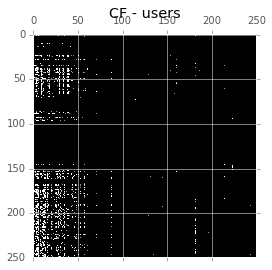

In [17]:
K=10
Y = dist.squareform(dist.pdist(Xflip, "jaccard"))
#find the closest K rows
Y = np.nan_to_num(Y) #house keeping for na's
U = np.argsort(Y)[:,:K]
#average them
out = np.mean(Xflip[U],1)
#threshold back to binary
out = stats.threshold(out,threshmax=0.5,newval=1)
out = stats.threshold(out,threshmin=0.49,newval=0)
plt.matshow(out,cmap='Greys_r')
print errors(X,out)
plt.title("CF - users")
plt.show()

For CF-items:

(0.14668333238647124, 0.4657073982014209)


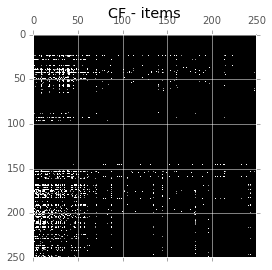

In [18]:
#produce a distance matrix
K=10
data = Xflip.T
Y = dist.squareform(dist.pdist(data, "jaccard"))
#find the closest K rows
Y = np.nan_to_num(Y) #house keeping for na's
U = np.argsort(Y)[:,:K]
#average them
out = np.mean(data[U],1)
#threshold back to binary
out = stats.threshold(out,threshmax=0.5,newval=1)
out = stats.threshold(out,threshmin=0.49,newval=0)
out = out.T
plt.matshow(out,cmap='Greys_r')
print errors(X,out)
plt.title("CF - items")
plt.show()

For SVD:

(0.08818163074019442, 0.30736589131166175)


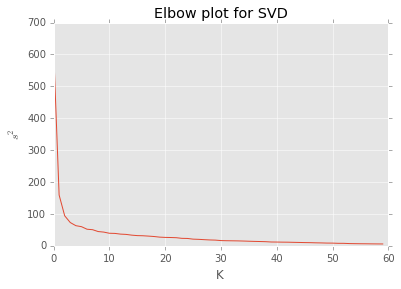

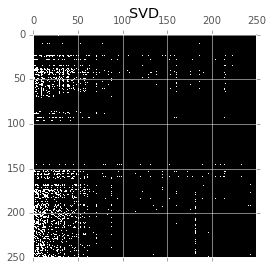

In [19]:
U, s, Vh = svd(Xflip)
plt.plot((s**2)[:60])
plt.xlabel("K")
plt.ylabel('$s^2$')
plt.title('Elbow plot for SVD')
s[30:]=0
out = np.round(np.dot(np.dot(U,diagsvd(s,Xflip.shape[0],Xflip.shape[1])),Vh))
plt.matshow(out,cmap='Greys_r')
print errors(X,out)
plt.title("SVD")
plt.show()

for Binary MF:

(0.13882894644486085, 0.43433087506288426)


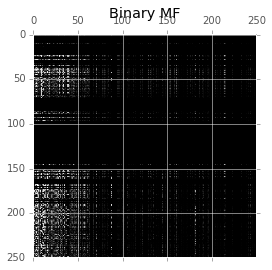

In [20]:
model = nimfa.mf(Xflip,  
                  rank = 10, 
                  method = "bmf", 
                  max_iter = 40, 
                  initialize_only = True,
                  version = 'r',
                  eta = 1.,
                  beta = 1e-4, 
                  i_conv = 10,
                  w_min_change = 0)
fit = nimfa.mf_run(model)
u = fit.basis()
v = fit.coef()
out = np.dot(u,v)
plt.matshow(out,cmap='Greys_r')
print errors(X,out)
plt.title("Binary MF")
plt.show()

Clearly the latent models perfrom the best,with a lowest sampled RMS and RMS, the CF based methods are some way behind.  SVD method produces the best result for sampledRMS, so not only is it quicker, gives more insight into the data, it also produces the best results on the most important measure, however MF shows good performance as well. It is worth noting that all results are sensitive to a $K$ value, which needs to be practically explored prior to committing to an algorithm.  

##Further Steps

So to summarise the following steps are necessary to build a system:

1. Collect Data together into matrix form - this will be either binary or integer. If the data is large then a sparse representation is most appropriate, in fact it may be the only way of holding the data in memory. The nimfa and SparseSVD libraries both handle this type of data.
2. Choose the algorithm for your particular and build prototype -  practically you must make a choice between SVD and MF, as we have shown both have benefits are there performance is comparable, MF slightly more accurate and SVD slightly more practical - you may wish to reperform the above comparison on your data it's a way of familarising yourself with the data - can be used in explaining the system to management, choose a small practical subset first.
3. Optimise performance - there is a K value for both SVD and MF - for SVD an elbow plot gives some indication of what value this might take (soemwhere around the elbow) and for MF a rule of thumb is to look at values around 1/10th of the dataset size.  
4. Build links to the front-end view - the final job is to present the data in some form, usually on a website this would be a recommendations bar below the search area (as Amazon do), other ways include followup emails. With interaction data the values are binary so they present a bag of possible recommendation rather than a ranked list, with source data the predicted integer values can be organised into a ranked list, and hence the highest value is the best recommendation.   

###The Future: Compressed Sensing

One area where matrix completion has made a significant recent impact is called
__Compressed Sensing__. A good example where this technique is applied is image acquisition.
A traditional digital camera produces a large image which is then stored efficiently on a disk 
often relying on a compression scheme to help produce the final data 
representation. The idea behind compressed sensing is to only sample a small number of sensed 
data, and then reconstruct the compressed signal from this, cutting 
down processing and storage requirements along the way (see diagram below). From this 
you can see the analogy with missing value interpolation of matrix 
completion as you are producing a final matrix from an intermediate 
representation with a lower number of data values. As if this isn't 
enough these schemes are also known to de-noise the data as well,  if 
there are noisy elements in the input data the process will not 
reproduce them! A truly exciting new method. How does it do 
this? Well the basis is an optimisation process but with an added penalty term ($l1$ which we will 
discuss in a future chapter) to make the final solution sparse.
If you want to find out more about this topic there is an excellent
summary paper by [Baraniuk](http://dsp.rice.edu/sites/dsp.rice.edu/files/cs/baraniukCSlecture07.pdf) and a more detailed mathematical exposition  in [Candes](http://authors.library.caltech.edu/10092/1/CANieeespm08.pdf), Baraniuk is particularly accessable.
 
 
<img src="files/CS.png">

#Summary

In this chapter we have looked at simple collaborative filtering and two more complex latent factor models (NMF and SVD) to build a recommender system. In general all techniques have predicted similar sensible looking completions, and can be implemented straightforwardly in Python with minimum fuss! 

Collaborative filtering has been explored as it simple to implement and produces sensible results, the maths and model are easy to interpret. In addition there are methods to speed this up with preindexing of the data-sets,should the data-set get large.

The Latent Factor techniques provide similar sensible results, however there is a danger with NMF due to the  uniqueness of the resultant model. SVD has been shown to be practical, and provide useful information (via the elbow plot) on whether a particular matrix has latent factors. Furthermore, the practical steps required to build an implementation for real-world sparse data have shown that using a `scipy` sparse format and it has been shown that MF and SVD gives good fast, memory efficient results, and offer significant perfromance benefits for largely sparse data.
 